<a href="https://colab.research.google.com/github/tluxxx/PortfolioExperiments/blob/main/macroeconomic_parameter_trading_(Gebert_type).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# trading using macroeconomic parameters
based on Gebert indicator

#1. General Preparations

In [ ]:
!pip install ecbdata

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import data processing libraries
import pandas as pd
import numpy as np
import datetime as dt

# import plotting libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import data providing libraries
import yfinance as yf
import pandas_datareader as pdr
from ecbdata import ecbdata

# import supporting modules
from scipy.stats import pearsonr

## 1.1. Helpers functions

In [ ]:
# Helper function for plotting indicator
def plot_ind_pos(pr, text_l, name, name_ind):
  ''' plotting (sub)-indicator value and color-coding of the proposed trade-position
  Args:
    pr (DataFrame):   dataframe with all required values (prices, sub-indicators, Geber-indicator, positions etc...)
    text_l:           long-text, describing the visualized (sub)-indicator
    name:             name of column in pr, that contains the indicator values
    name_ind:         name of column in pr, that contains the proposed trade postion (0 = FLAT, 1=LONG)
  Returns:
    (none)
  '''
  # title of plot
  main_title= f'timeline of {text_l}  ({name}) and trade-position recommendations from sub-indicator-value'
  sub_title = f'instrument: {ticker}, analyzed  from: {start_assessment} to: {end_period} '
  title = main_title + '<br><br><sup>' + sub_title + '</sup>'

  # preparation
  x = pr[name]
  ind = pr[name_ind]

  y1 = np.where(((pr[name_ind] == 1) | (pr[name_ind].pct_change() < 0)), pr[name], np.nan)
  y2 = np.where(((pr[name_ind] == 0) | (pr[name_ind].pct_change() > 1)), pr[name], np.nan)
  colors = ['green','red']

  # plotting
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=params.index, y=y1, line_width = 3, line_color =  colors[0], name = f'{name} - (sub)-indicator = 1 (recommending LONG)'))
  fig.add_trace(go.Scatter(x=params.index, y=y2, line_width = 3, line_color = colors[1], name = f'{name} - (sub)-indicator = 0 (recommending FLAT)'))

  fig.update_layout(template='plotly_dark', autosize=False, width=1600, height=400)
  fig.update_layout(title=title, xaxis_title='time', yaxis_title=f'subindcator {name_ind}', legend_title='Positions')
  fig.show()


# helper fuction to calculate all PnL's
def pnl_calc_all(pr, start):
  ''' calculation of the following PnL's (w/o fees):
      * Strategy-Indicator (accumulated returns)
      * all substrategies (season, EU-USD, inflation (EUa, GER), CB-key-interest rate)
      * Buy and Hold
      without fees [using GER and EU-aggregated inflation data]
  Args:
    pr (DataFrame):   dataframe with all required values (prices, sub-indicators, Strategy-indicators, positions etc...)
    start:            start date of the asssesment of the data
  Returns:
      pr_c:           dataframe supplemented by the PnL data of Strategty and B&H
  '''

  # preparation
  prc = pr.loc[start:].copy()

  # PnL of single strategies
  prc['pnl_infl_GER'] = (1 + prc['dax'].pct_change() * prc['pos_infl_GER'].shift(1)).cumprod()
  prc['pnl_infl_EUa'] = (1 + prc['dax'].pct_change() * prc['pos_infl_EUa'].shift(1)).cumprod()
  prc['pnl_int'] = (1 + prc['dax'].pct_change() * prc['pos_int'].shift(1)).cumprod()
  prc['pnl_eur_usd'] = (1 + prc['dax'].pct_change() * prc['pos_eur_usd'].shift(1)).cumprod()
  prc['pnl_season'] = (1 + prc['dax'].pct_change() * prc['pos_season'].shift(1)).cumprod()

  # PnL of Strategy-Indicator
  prc['pnl_GI_GER'] = (1 + prc['dax'].pct_change() * prc['pos_GI_GER'].shift(1)).cumprod()
  prc['pnl_GI_EUa'] = (1 + prc['dax'].pct_change() * prc['pos_GI_EUa'].shift(1)).cumprod()

  # Buy and Hold data as reference
  prc['pnl_buh'] = (1 + prc['dax'].pct_change()).cumprod()

  x = ['pnl_infl_GER', 'pnl_infl_EUa', 'pnl_int', 'pnl_eur_usd', 'pnl_season', 'pnl_GI_GER', 'pnl_GI_EUa', 'pnl_buh']
  prc.loc[prc.index[0], x] = 1

  return prc

# Helper function for plotting the PnL from a strategy list
def plot_pnl_simple(pr, start, end, st_list):
  ''' plotting of PnL-curves of sub-strategies from a strategy-list (st_list)
  Args:
    pr (DataFrame):   dataframe with all required values (prices, sub-indicators, Geber-indicator, positions etc...)
    start:            start date of the asssesment of the data
    end:              end date of the plot
    st_list:          list of strategies (=columns in pr), that should be plotted
  Returns:
    (none)
  '''
  main_title = f'PnL-development of (sub)-strategies vs. B&H'
  sub_title = f'instrument: {ticker}, analyzed  from: {start} to: {end}'
  title = main_title + '<br><br><sup>' + sub_title + '</sup>'
  fig = go.Figure()

  for strategy in st_list:
    name_x = 'pnl_' + strategy
    fig.add_trace(go.Scatter(x=pr.index, y=pr[name_x], name=f'{name_x}'))

  fig.add_trace(go.Scatter(x=pr.index, y=pr['pnl_buh'], name = 'pnl_buh'))
  fig.update_layout(template='plotly_dark', autosize=False, width=1300, height=600)
  fig.update_layout(title=title, xaxis_title='time', yaxis_title= 'PnL-Strategies and Buy&Hold', legend_title='Strategy')
  fig.show()

# Helper function to plot the PnL, the position and the value of the GI-Indicator
def plot_pnl_ind(pr, mode, source, start, end, ticker):
  ''' plot of PnL of Strategy-strategy (accumulated returns)and plot of PnL of B&H (w/o fees)
      plot of Strategy-indicator-values and of positions
  Args:
    pr (DataFrame):   dataframe with all required values (prices, sub-indicators, Strategy-indicator, positions etc...)
    mode:             if set to 'log' the PnL will be displayed in logarithmic scale
    ticker:           ticker of the instrument
    start:            start date of the asssesment of the data
  Returns:
      none:           plot of the PnL and subplots of Strategy-indicator and position
  '''
  # preparation
  name_pnl = 'pnl_GI_' + source
  name_ind = 'GI_' + source
  name_pos = 'pos_GI_' + source

  # plotting
  if source == 'GER':
    data_source = 'inflation-data from Germany'
  elif source == 'EUa':
    data_source = 'inflation-data from EU-aggregated'

  main_title = f'development of PnL position of Strategy ({data_source}) vs. B&H'
  sub_title = f'instrument: {ticker}, analyzed  from: {start} to: {end}'
  title = main_title + '<br><br><sup>' + sub_title + '</sup>'

  fig = make_subplots(rows=3, cols=1, row_heights=[0.7,0.1,0.1], shared_xaxes=True, vertical_spacing=0.02)
  fig.add_trace(go.Scatter(x=pr.index, y=pr[name_pnl], name = f'Strategy ({data_source}) - accumulated returns'), row=1, col=1)
  fig.add_trace(go.Scatter(x=pr.index, y=pr['pnl_buh'], name = 'Buy and Hold'), row=1, col=1)
  fig.add_trace(go.Scatter(x=pr.index, y=pr[name_ind], line_shape='hv', line_color='lightgreen', name = f'Strategy-Indicator-Value ({data_source})'), row=2, col=1)
  fig.add_trace(go.Scatter(x=pr.index, y=pr[name_pos], line_shape='hv', line_color='green', fill='tozeroy', name=f'position ({data_source})'), row=3, col=1)

  fig.update_layout(title=title, legend_title ='Sources', template='plotly_dark', autosize=False, width=1500, height=700)

  if mode =='log':
    fig.update_yaxes(type='log', title_text='log(PnL)', row=1, col=1)
  else:
    fig.update_yaxes(title_text='PnL', row=1, col=1)

  fig.update_yaxes(title_text='GI', row=2, col=1)
  fig.update_yaxes(title_text='position', row=3, col=1)
  fig.update_xaxes(title_text='time', row=3, col=1)
  fig.show()

#2. Downloading required data and data preparations

## 2.1 DAX-data & trading/analyses days

In [ ]:
# importing the DAX-data
start_period, end_period = '1992-01-01', '2024-06-30'   # download data for analyses and indicator calculations
start_assessment = '1993-01-01'                         # start of evaluation of indicators
start_analyses = '1991-12-31'

ticker ='^GDAXI'
dax_d = yf.download(ticker, start=start_period, end=end_period)

# adding a field data to support resampling
dax_d['date'] = pd.to_datetime(dax_d.index).date

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# General preparations

## calculation of first and last calendar day of a month (last calendar day = date of data-observation and analyses)
dates_start_m = pd.date_range(start_period, end_period, freq ='MS')
dates_end_m = pd.date_range(start_period, end_period, freq ='M')

## calculation of the first trading day of a month (from yfinance-time-series)
trade_dates_m = pd.to_datetime(dax_d.resample('MS').first()['date'].to_list())

## generation of result-dataframe (params)
params = pd.DataFrame({'trade_dates':trade_dates_m,
                       'end_dates': dates_end_m},
                      index=dates_start_m)

## modifying the result-dataframe (params) and generation lists of analyses-dates
params['analyses_dates'] = params.end_dates.shift(1)
params.loc[params.index[0],'analyses_dates'] = dt.datetime.strptime(start_analyses, '%Y-%m-%d')
params.drop('end_dates', axis=1, inplace=True)
analyses_dates_m = params['analyses_dates'].tolist()

## 2.2 Inflation Data

In [ ]:
# reading and preparing inflation data for 1991-2024

# preparations
start_GER_data = '1991-01-01'
start_ecb_data ='1997-01-01'
switch_date_inf ='1998-01-31'

# data from German Statistical Office (1992-2024) [note: only CPI data available prior to 1992]
data_ger = pd.read_excel('/content/gdrive/My Drive/ColabNotebooks/VariousTopics/PortfolioTests/data/GermanInflationDataRevised(1991-2024).xlsx', sheet_name='DATA')

end_dates_GER = pd.date_range(start_GER_data, end_period, freq ='M')
inf_GER = pd.DataFrame({'inflation_12m': data_ger['chg_12m'].to_list()},
                       index=end_dates_GER.tolist())

# download data from ECB (1997-2024)
data_key = 'ICP.M.U2.N.000000.4.ANR'  # HICP - Overall index, Euro area (changing composition), Monthly
inf_eu = ecbdata.get_series(data_key, start=start_period, end=end_period)
inf_eu.TIME_PERIOD = pd.to_datetime(inf_eu.TIME_PERIOD)
inf_eu = inf_eu.set_index('TIME_PERIOD')
inf_eu = inf_eu.OBS_VALUE.astype(float)
end_dates = pd.date_range(start_ecb_data, end_period, freq ='M')
inf_EU = pd.DataFrame({'inflation_12m':inf_eu.tolist()},
                      index=end_dates.tolist())

# Adaptation of the GER-data-frame to start_period
inf_GER = inf_GER.loc[start_period:]
inf_GER.inflation_12m.astype(float)

# Combination of GER and ECB time-series at a cut-off-date
df1 = inf_GER.loc[start_period:switch_date_inf]
df2 = inf_EU.loc[switch_date_inf:]
inf_EUa = pd.concat([df1,df2])
if inf_EUa.index.duplicated().any():
  inf_EUa = inf_EUa[~inf_EUa.index.duplicated(keep='first')]  # Keep the first occurrence



## 2.3. Interest Rates

In [ ]:
# reading and preparing interest data from different Central Bank Sources

# preparation
switch_date_int = '1998-12-31'                           # switch from German Bundesbank-data to ECB-data
start_upload = dt.datetime.strptime(start_period, '%Y-%m-%d') - dt.timedelta(31)   # ensuring data are available for early 1993

# upload German Bundesbank discount rates (from previously downloaded file)
## file contains the original Bundesbank discount rate timeline and a sheet with discount rates/change dates
data_db = pd.read_excel('/content/gdrive/My Drive/ColabNotebooks/VariousTopics/PortfolioTests/data/DiscountRatesGermanBundesbankRevised_until_1998.xlsx',sheet_name='DATA' )
data_db['date'] = pd.to_datetime(data_db['dates'])
data_db.set_index('date', inplace=True)
data_db.drop(['dates','comment'], axis=1, inplace=True)
data_db.rename(columns = {'rate':'interest'}, inplace = True)

## transfer into a daily dataframe, forward fill the current discount rate
temp = pd.DataFrame(index=pd.date_range('1948-01-01', '1998-12-31'))
db_dr = pd.merge(temp, data_db, how='left', left_index=True, right_index=True)
db_dr.ffill(inplace=True)

# fetch ECB key interest data (for each calendar day)
# key interest rate: Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level, Euro area (changing composition), Daily
data_key = 'FM.D.U2.EUR.4F.KR.MRR_RT.LEV'
ecb = ecbdata.get_series(data_key, start=start_period, end=end_period)
ecb.TIME_PERIOD = pd.to_datetime(ecb.TIME_PERIOD)
ecb = ecb.set_index('TIME_PERIOD')
ecb = ecb.OBS_VALUE.astype(float)
ecb_int = pd.DataFrame({'interest':ecb.tolist()}, index=ecb.index)
ecb_int.rename(columns = {'OBS_VALUE':'interest'}, inplace = True)

# aggregation of Bundesbank-Discount rates and ECB-rates to one daily timeline, filtering for the analyses days
intr_agg = pd.concat([db_dr,ecb_int])
interest_agg = intr_agg.loc[analyses_dates_m]

## 2.3 Exchange rates EURO - USD

In [ ]:
# Exchange rates EURO-USD

# preparation
switch_date_curr = '1999-01-01'                     # switch from German Bundesbank to ECB data
dates_d = pd.date_range(start_upload, end_period)   # data-window
init_d = np.nan

# uploading USD-DM historical exchange rates (previously downloaded from German Bundesbank)
data_db = pd.read_excel('/content/gdrive/My Drive/ColabNotebooks/VariousTopics/PortfolioTests/data/ExchangeRates_(USD_DM)_(until 1998).xlsx', sheet_name='DATA')

# processing USD-DM data  (daily data for each German Bank Day)
data_db[data_db['data'] =='.'] = np.nan
data_db.rename(columns = {'data':'rate'}, inplace = True)
data_db.dropna(inplace=True)
data_db.set_index('date', inplace=True)
data_db = data_db.rate.astype(float)

# conversion of relevant USD-DM data (from start_period) to EUR-USD
usd_dm_db = data_db.loc[start_upload:]            # USD-DM data
eur_usd_db = 1 / usd_dm_db.div(1.95583)           # reverting the currency pair and transforming to EURO
eur_usd_db.name = 'rate'

# importing the relevant EURO-USD historical exchange rates from FRED (daily data for each US bank day) (series starts at switch_date_curr)
eur_usd_fred = pdr.data.DataReader('DEXUSEU', 'fred', switch_date_curr, end_period)
eur_usd_fred.rename(columns = {'DEXUSEU':'rate'}, inplace = True)
eur_usd_fred['rate'].ffill(inplace=True)
eur_usd_fred = eur_usd_fred['rate']

# combining Bundesbank and FRED data to one timeseries and storing in an aggregated time-series
eur_usd = pd.concat([eur_usd_db, eur_usd_fred])
eur_usd_temp1 = pd.DataFrame({'rate':init_d}, index=dates_d)
eur_usd_temp2 = pd.merge(eur_usd_temp1, eur_usd, how='left', left_index=True, right_index=True)['rate_y']
eur_usd_temp2.name ='rate'
eur_usd_temp2.ffill(inplace=True)
eur_usd_agg = eur_usd_temp2[eur_usd_temp2.index.isin(analyses_dates_m)]
eur_usd_agg.name = 'exchange_rate'

# 3. System-Indicator and Trade Positions

## 3.1 Calculation

In [ ]:
# collecting raw data for System Indicator-Calculation

# collection of monthly dax-data   [close of the first trading day of the month]
params['dax'] = dax_d[dax_d.index.isin(trade_dates_m)]['Close'].tolist()

# collection of monthly inflation-data, shifting, to reflect that at first trading day of a month, inflation date are not ready yet!
params['infl_GER'] = inf_GER['inflation_12m'].shift(2).tolist()
params['infl_EUa'] = inf_EUa['inflation_12m'].shift(2).tolist()


# collection of monthly interest-data, exchange-rate data and seasoality
params['int'] = interest_agg.interest.tolist()
params['eur_usd'] = eur_usd_agg.tolist()
params['season'] = params.index.month


In [ ]:
params.tail()

,trade_dates,analyses_dates,dax,infl_GER,infl_EUa,int,eur_usd,season
2024-02-01,2024-02-01,2024-01-31,16859.039062,3.7,2.9,4.5,1.0855,2
2024-03-01,2024-03-01,2024-02-29,17735.070312,2.9,2.8,4.5,1.0807,3
2024-04-01,2024-04-02,2024-03-31,18283.130859,2.5,2.6,4.5,1.0791,4
2024-05-01,2024-05-02,2024-04-30,17896.500000,2.2,2.4,4.5,1.0684,5
2024-06-01,2024-06-03,2024-05-31,18608.160156,2.2,2.4,4.5,1.0846,6


In [ ]:
# calculation of subindicators (= sub positions of trades),
# the resulting System-Indicator (GI) and the GI-based trade-positons

# subindicator interest (= pos_int):
## +1 (LONG): if last adaptation of CB's benchmark interest rate was a reduction,
##  0 (FLAT): otherwise
interest_chg = params['int'].diff()
params['pos_int'] = np.select([interest_chg < 0, interest_chg > 0, interest_chg == 0], [1, 0, np.nan])
params['pos_int'].ffill(inplace=True)

# subindicator inflation (= pos_infl_X):
## +1 (LONG): if inflation rate declined, compared to -12m value,
##  0 (FLAT): otherwise
params['pos_infl_GER'] = np.where(params['infl_GER'] < params['infl_GER'].shift(12), 1, 0)
params['pos_infl_EUa'] = np.where(params['infl_EUa'] < params['infl_EUa'].shift(12), 1, 0)

# subindicator exchange rates USD/EUR (= pos_eur_usd):
## +1 (LONG): if USD got stronger compared to -12m,
##  0 (FLAT): otherwise
params['pos_eur_usd'] = np.where(params['eur_usd'] < params['eur_usd'].shift(12), 1, 0)

# subindicator seasonality (= pos_season):
## +1 (LONG): during [November -April],
##  0 (FLAT): otherwise
params['pos_season'] = np.where(params['season'].isin([11,12,1,2,3,4]), 1, 0)

# calculation of Sustem-Indicator (GI_X) from the subindicators
i_GER = ['pos_int', 'pos_infl_GER', 'pos_eur_usd', 'pos_season']
i_EUa = ['pos_int', 'pos_infl_EUa', 'pos_eur_usd', 'pos_season']
params['GI_GER'] = params[i_GER].sum(axis=1)
params['GI_EUa'] = params[i_EUa].sum(axis=1)

# calculation of GI-based trade positons (pos_GI_X):
## GI=3,4 stay/go LONG;
## GI=0,1 stay/go FLAT,
## GI=2 keep positions
cond_GER = [params['GI_GER'] <= 1, params['GI_GER'] >= 3, params['GI_GER'] == 2]
cond_EUa = [params['GI_EUa'] <= 1, params['GI_EUa'] >= 3, params['GI_EUa'] == 2]
choices = [0, 1, np.nan]
params['pos_GI_GER'] = np.select(cond_GER, choices)
params['pos_GI_EUa'] = np.select(cond_EUa, choices)
params['pos_GI_GER'].ffill(inplace=True)
params['pos_GI_EUa'].ffill(inplace=True)

# finetuning:
col_list = ['pos_int', 'GI_GER', 'GI_EUa', 'pos_GI_GER', 'pos_GI_EUa']
params[col_list] = params[col_list].astype(int)


In [ ]:
## option to download and cross check sub-inidcator data
params.to_excel('/content/gdrive/My Drive/ColabNotebooks/VariousTopics/PortfolioTests/results/ME_TradeSystemIndicator_GI_RawData.xlsx')

## 3.2. Visualisation of System Indicator and of Sub-indicators

In [ ]:
# Visualiation sub-indicator inflation (Germany)
text_long, parameter, indicator = 'inflation (Germany)', 'infl_GER', 'pos_infl_GER'
pr_x = params.loc[start_assessment:].copy()
plot_ind_pos(pr_x, text_long, parameter, indicator)

In [ ]:
# Visualiation sub-indicator inflation (EU-aggregated)
text_long, parameter, indicator = 'inflation (EU-aggregated)', 'infl_EUa', 'pos_infl_EUa'
plot_ind_pos(pr_x, text_long, parameter, indicator)

In [ ]:
# Visualiation sub-indicator central-bank-interest-rate
text_long, parameter, indicator = 'Central Bank interest rate', 'int', 'pos_int'
plot_ind_pos(pr_x, text_long, parameter, indicator)


In [ ]:
# Visualiation sub-indicator EUR-USD-exchange-rate
text_long, parameter, indicator = 'EUR-USD-exchange-rate (aggregated)', 'eur_usd', 'pos_eur_usd'
plot_ind_pos(pr_x, text_long, parameter, indicator)

In [ ]:
# Visualiation Strategy indicator (GER-data for inflation)
text_long, parameter, indicator = 'Strategy-indicator (inflation data: Germmany)', 'GI_GER', 'pos_GI_GER'
plot_ind_pos(pr_x, text_long, parameter, indicator)

In [ ]:
# Visualiation Gebert indicator (EU-aggregated-data for inflation)
text_long, parameter, indicator = 'Strategy-indicator (inflation data: EU-aggregated)', 'GI_EUa', 'pos_GI_EUa'
plot_ind_pos(pr_x, text_long, parameter, indicator)

# 4. Results

## 4.1. PnL-curves

In [ ]:
# PnL-calculations for all strategies (GI- and sub-indicator-based) during (start_asessment to end_period)
params_c = pnl_calc_all(params, start_assessment)

## ploting PnL from sub-indicators
sub_strategies = ['infl_GER', 'infl_EUa', 'int', 'eur_usd', 'season']
plot_pnl_simple(params_c, start_assessment, end_period, sub_strategies)

In [ ]:
print('Overview of final results of sub-strategies')
print(f'final PnL sub-strategy season:                    {params_c.pnl_season.iloc[-1]:.2f}')
print(f'final PnL sub-strategy inflation EU:              {params_c.pnl_infl_EUa.iloc[-1]:.2f}')
print(f'final PnL sub-strategy inflation GER:             {params_c.pnl_infl_GER.iloc[-1]:.2f}')
print(f'final PnL sub-strategy key interest rate:         {params_c.pnl_int.iloc[-1]:.2f}')
print(f'final PnL sub-strategy EUR-USD-exchange-rate:     {params_c.pnl_eur_usd.iloc[-1]:.2f}')
print(f'final PnL Buy & Hold:                             {params_c.pnl_buh.iloc[-1]:.2f}')

Overview of final results of sub-strategies
final PnL sub-strategy season:                    14.55
final PnL sub-strategy inflation EU:              12.98
final PnL sub-strategy inflation GER:             8.37
final PnL sub-strategy key interest rate:         11.17
final PnL sub-strategy EUR-USD-exchange-rate:     7.19
final PnL Buy & Hold:                             12.10


In [ ]:
# plotting PnL for GI-strategies (based on GER or on EU-aggregated data)
main_strategies = ['GI_GER', 'GI_EUa']
plot_pnl_simple(params_c, start_assessment, end_period, main_strategies)

In [ ]:
print('Overview of final results of Strategies')
print(f'final PnL Strategy (German inflation Data):        {params_c.pnl_GI_GER.iloc[-1]:.2f}')
print(f'final PnL Strategy (EU-aggregated inflation Data): {params_c.pnl_GI_EUa.iloc[-1]:.2f}')
print(f'final PnL Buy & Hold:                              {params_c.pnl_buh.iloc[-1]:.2f}')

Overview of final results of Strategies
final PnL Strategy (German inflation Data):        28.12
final PnL Strategy (EU-aggregated inflation Data): 28.70
final PnL Buy & Hold:                              12.10


In [ ]:
# more detailed plot
source ='EUa'   # 'GER' or 'EUa'
mode = 'nonlog'
plot_pnl_ind(params_c, mode, source, start_assessment, end_period, ticker)

In [ ]:
start_assessment = '1993-01-01'
params_c = pnl_calc_all(params, start_assessment)

# DEEPER-DIVE: Drawdown (%) (based on European inflation data)

x0 = ((params_c['pnl_GI_EUa'] / params_c['pnl_GI_EUa'].expanding().max()) - 1) * 100
x1 = ((params_c['pnl_buh'] / params_c['pnl_buh'].expanding().max()) - 1) * 100

main_title = 'drawdown Strategy (inflation data: EU-aggregated) vs. Buy & Hold'
sub_title = f'instrument: {ticker}   from   {start_assessment}   to   {end_period} '
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

fig = go.Figure()
fig.add_trace(go.Scatter(x=x0.index, y=x0, mode='none', fill='tozeroy', fillcolor='rgba(0, 255, 0, 0.3)', name='Strategy'))
fig.add_trace(go.Scatter(x=x1.index, y=x1, mode='none', fill='tozeroy', fillcolor='rgba(255, 255, 0, 0.3)', name='Buy & Hold'))
fig.update_layout(template = 'plotly_dark',autosize=False, width=1500, height=400)
fig.update_layout(title=title, xaxis_title='date', yaxis_title='drawdown (%)')
fig.show()

In [ ]:
# DEEPER DIVE: visualisation with log scale for Pnl
source = 'EUa'
mode = 'log'  # 'log' or 'nonlog'
plot_pnl_ind(params_c, mode, source, start_assessment, end_period, ticker)

In [ ]:
# DEEPER-DIVE: Outperformance Gebert-Strategy vs B&H over time

# preparation
x = (params_c['pnl_GI_EUa']/params_c['pnl_buh'])

main_title = f'development of outperformance ( = (PnL-Strategy/ PnL-B&H) over time, based on Strategy (inflation-data: EU-aggregated)'
sub_title = f'instrument: {ticker}, analyzed  from: {start_assessment} to: various end-dates'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=x.index, y=x, name = f'Gebert Strategy (inflation-data EU-aggregated) - accumulated returns'))
fig.update_layout(template = 'plotly_dark',autosize=False, width=1500, height=400)
fig.update_layout(title=title, xaxis_title='end-date', yaxis_title='Outperformance')
fig.show()

In [ ]:
# DEEPER DIVE: Study of alternative start days
start_date_alternative = '2015-01-01'
source = 'EUa'
params_c = pnl_calc_all(params,start_date_alternative)
plot_pnl_ind(params_c, 'nonlog', source, start_date_alternative, end_period, ticker)

In [ ]:
# deeper dive simulation of the Outperformance of Gebert-indicator strategy vs B&H at various start dates for strategy implementation
# verification period
start_verification = '1993-01-01'
end_verification = '2019-12-31'

# preparations
test_starts = pd.date_range(start=start_verification, end=end_verification, freq='MS')
results_strat, results_buh = [], []

# calculations
for start in test_starts:
  pr_filt = params.loc[start:].copy()
  pr_test = pnl_calc_all(pr_filt, start)
  results_strat.append(pr_test['pnl_GI_EUa'].iloc[-1])
  results_buh.append(pr_test['pnl_buh'].iloc[-1])

#compilation of the final results
results = pd.DataFrame({'pnl_dyn_EUa':results_strat,
                        'pnl_dyn_buh': results_buh},
                       index= test_starts)
x = results['pnl_dyn_EUa'] / results['pnl_dyn_buh']

# plotting
main_title = f'outperformance (PnL-Strat / PnL-B&H) depending of start of strategy implementation (Strategy, inflation-data: EU-aggregated)'
sub_title = f'instrument: {ticker}, analyzed  from: various start_dates to:{end_period}'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

fig = go.Figure()
fig.add_trace(go.Scatter(x=x.index, y=x, name = f'Strategy (inflation-data EU-aggregated) - accumulated returns'))
fig.update_layout(template = 'plotly_dark',autosize=False, width=1500, height=400)
fig.update_layout(title=title, xaxis_title='date of start of strategy implementation', yaxis_title='Outperformance')
fig.show()

# ANNEX:VERIFICATION

In [ ]:
# Alternatives Downloading via ECB-data-portal

data_key = 'EXR.D.USD.EUR.SP00.A'
ecb = ecbdata.get_series(data_key, start=start_period, end=end_period)
ecb.TIME_PERIOD = pd.to_datetime(ecb.TIME_PERIOD)
ecb = ecb.set_index('TIME_PERIOD')
ecb = ecb.OBS_VALUE.astype(float)

ecb_rat = pd.DataFrame({'rate': ecb.tolist()}, index=ecb.index)
ecb_rat.rename(columns = {'OBS_VALUE':'rate_ECB'}, inplace = True)



maximal abs difference: 0.031800   max positive difference: 0.030500    max negative difference -0.031800



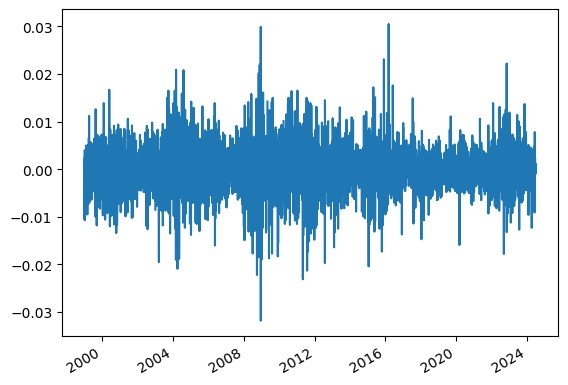

In [ ]:
# merging FRED and ECB data
x =pd.merge(eur_usd_fred, ecb_rat, left_index=True, right_index=True)
diff = x.rate_x-x.rate_y
diff.plot()
print('')
print(f'maximal abs difference: {max(abs(diff)):.6f}   max positive difference: {max(diff):.6f}    max negative difference {min(diff):.6f}')
print('')

In [ ]:
intervall = pd.date_range('2024-03-25', '2024-04-05')
x[x.index.isin(intervall)]

,rate_x,rate_y
2024-03-25,1.0837,1.0835
2024-03-26,1.0829,1.0855
2024-03-27,1.0821,1.0816
2024-03-28,1.0801,1.0811
2024-04-02,1.0769,1.0749
2024-04-03,1.0827,1.0783
2024-04-04,1.0865,1.0852
2024-04-05,1.0841,1.0841


In [ ]:
intervall = pd.date_range('2023-03-25', '2023-04-05')
x[x.index.isin(intervall)]

,rate_x,rate_y
2023-03-27,1.0789,1.0773
2023-03-28,1.0844,1.0841
2023-03-29,1.0826,1.0847
2023-03-30,1.0899,1.0886
2023-03-31,1.0872,1.0875
2023-04-03,1.0891,1.0870
2023-04-04,1.0951,1.0901
2023-04-05,1.0918,1.0940
